In [46]:
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
import numpy as np
import keras
import keras.backend as K
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import random
import time
import math
import os
import folium
from shapely.geometry import Point, Polygon

In [47]:
summer_data = pd.read_csv("../data/hourly readings/fixed_summer_hourly.csv")
winter_data = pd.read_csv("../data/hourly readings/fixed_winter_hourly.csv")

In [48]:
summer_data['datetime'] = pd.to_datetime(summer_data['timestamp'], unit='s')
winter_data['datetime'] = pd.to_datetime(winter_data['timestamp'], unit='s')

In [49]:
summer_data

,timestamp,sensor ID,latitude,longitude,pm2.5(ug/m3),pm10(ug/m3),datetime
0,1657263600,f1,53.390659,-6.201700,1.25,1.55,2022-07-08 07:00:00
1,1657267200,f1,53.390659,-6.201700,1.64,1.97,2022-07-08 08:00:00
2,1657270800,f1,53.390659,-6.201700,3.34,3.78,2022-07-08 09:00:00
3,1657274400,f1,53.390659,-6.201700,2.90,3.29,2022-07-08 10:00:00
4,1657278000,f1,53.390659,-6.201700,2.70,3.10,2022-07-08 11:00:00
...,...,...,...,...,...,...,...
34575,1657357200,f23,53.320393,-6.307228,0.19,0.29,2022-07-09 09:00:00
34576,1657422000,f23,53.320393,-6.307228,3.55,3.84,2022-07-10 03:00:00
34577,1657425600,f23,53.320393,-6.307228,4.57,5.07,2022-07-10 04:00:00
34578,1657429200,f23,53.320393,-6.307228,7.45,8.29,2022-07-10 05:00:00


In [50]:
summer_data.dtypes

timestamp                int64
sensor ID               object
latitude               float64
longitude              float64
pm2.5(ug/m3)           float64
pm10(ug/m3)            float64
datetime        datetime64[ns]
dtype: object

In [51]:
winter_data

,timestamp,sensor ID,latitude,longitude,pm2.5(ug/m3),pm10(ug/m3),datetime
0,1633046400,f1,53.390659,-6.201700,1.93,3.26,2021-10-01 00:00:00
1,1633050000,f1,53.390659,-6.201700,1.79,3.13,2021-10-01 01:00:00
2,1633053600,f1,53.390659,-6.201700,1.33,2.50,2021-10-01 02:00:00
3,1633057200,f1,53.390659,-6.201700,0.57,1.39,2021-10-01 03:00:00
4,1633060800,f1,53.390659,-6.201700,0.38,1.15,2021-10-01 04:00:00
...,...,...,...,...,...,...,...
42080,1643652000,f23,53.320393,-6.307228,6.76,8.73,2022-01-31 18:00:00
42081,1643655600,f23,53.320393,-6.307228,8.06,10.25,2022-01-31 19:00:00
42082,1643659200,f23,53.320393,-6.307228,5.75,7.85,2022-01-31 20:00:00
42083,1643662800,f23,53.320393,-6.307228,4.62,6.62,2022-01-31 21:00:00


In [52]:
winter_data.dtypes

timestamp                int64
sensor ID               object
latitude               float64
longitude              float64
pm2.5(ug/m3)           float64
pm10(ug/m3)            float64
datetime        datetime64[ns]
dtype: object

In [53]:
summer_data_dropped = summer_data.drop_duplicates(subset=['sensor ID'])

In [54]:
summer_data_dropped

,timestamp,sensor ID,latitude,longitude,pm2.5(ug/m3),pm10(ug/m3),datetime
0,1657263600,f1,53.390659,-6.201700,1.25,1.55,2022-07-08 07:00:00
551,1648771200,f2,53.391046,-6.168369,5.46,6.73,2022-04-01 00:00:00
3387,1648771200,f3,53.369354,-6.258590,4.42,5.13,2022-04-01 00:00:00
6272,1648771200,f4,53.387039,-6.258155,3.96,5.10,2022-04-01 00:00:00
9086,1651575600,f6,53.320382,-6.362783,11.59,12.64,2022-05-03 11:00:00
9753,1651820400,f7,53.389831,-6.304962,0.29,0.59,2022-05-06 07:00:00
11712,1648771200,f8,53.390743,-6.264541,4.07,5.46,2022-04-01 00:00:00
14571,1648771200,f9,53.344090,-6.272385,5.30,6.43,2022-04-01 00:00:00
17202,1648771200,f10,53.344617,-6.254761,5.58,6.92,2022-04-01 00:00:00
19991,1648771200,f14,53.321945,-6.267489,3.70,4.61,2022-04-01 00:00:00


In [55]:
# Create a map centered on Dublin
m = folium.Map(location=(summer_data_dropped["latitude"].values[0], summer_data_dropped["longitude"].values[0]), zoom_start=11)


# Display the map

# # Add markers for each coordinate
for index, row in summer_data_dropped.iterrows():
    coord = (row["latitude"], row["longitude"])
    folium.Marker(location=coord,popup=row["sensor ID"],tooltip=folium.Tooltip(row["sensor ID"])).add_to(m)
    
m

In [56]:
import matplotlib.dates as mdates
def plt_sensor(df, title):
    plt.figure(figsize=(16, 6))
#     timeframe = df[(df['datetime'] >= '2022-01-01')
#                              & (df['datetime'] <= '2022-12-31')]
    
    sns.lineplot(data = df, x='datetime', y='pm10(ug/m3)', label="pm10")
    sns.lineplot(data = df, x='datetime', y='pm2.5(ug/m3)', label="pm2.5")
    plt.xlabel('Date')
    plt.ylabel('Concentration')
    plt.title(title)
    plt.legend()

    date_formatter = mdates.DateFormatter('%b %Y')  # Format as abbreviated month and year (e.g., Jan 2022)
    desired_tick_frequency = mdates.MonthLocator()
    # Apply the tick frequency and formatter to the x-axis
    plt.gca().xaxis.set_major_locator(desired_tick_frequency)
    plt.gca().xaxis.set_major_formatter(date_formatter)

    plt.show()

In [57]:
summer_s1 = summer_data[summer_data['sensor ID'] == 'f15']

In [58]:
summer_s2 = summer_data[summer_data['sensor ID'] == 'f23']

In [59]:
winter_s1 = winter_data[winter_data["sensor ID"] == "f15"]

In [60]:
winter_s2 = winter_data[winter_data["sensor ID"] == "f23"]

In [61]:
s1 = pd.concat([summer_s1, winter_s1], axis=0)

In [62]:
s1['datetime'].min()

Timestamp('2021-10-01 00:00:00')

In [63]:
s1['datetime'].max()

Timestamp('2022-07-31 22:00:00')

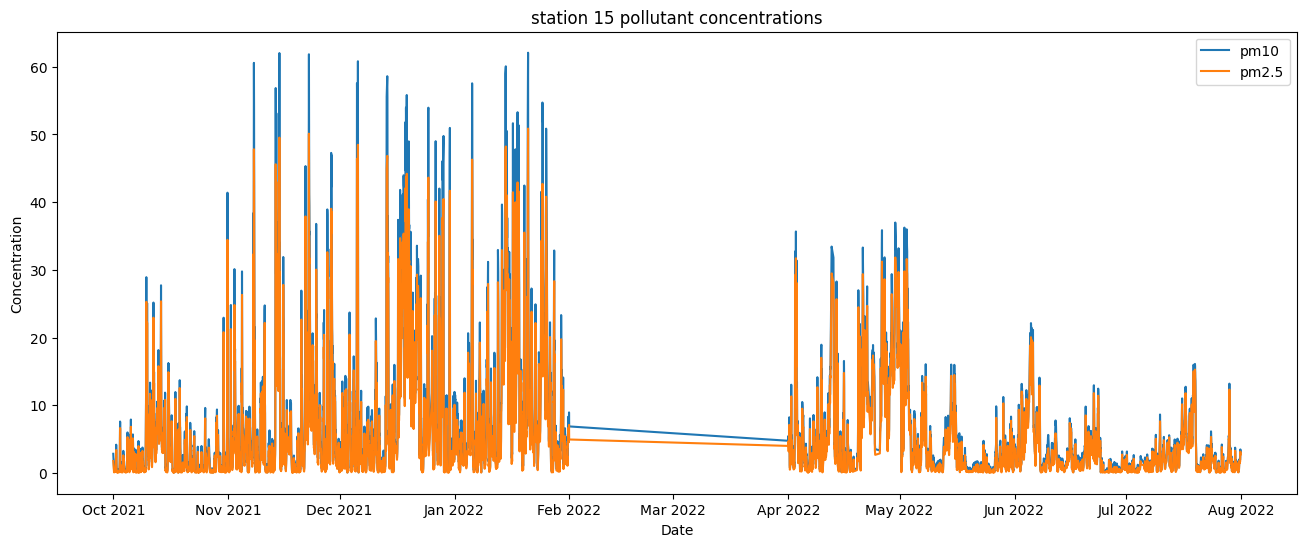

In [64]:
plt_sensor(s1, "station 15 pollutant concentrations")

In [65]:
s1.describe()

,timestamp,latitude,longitude,pm2.5(ug/m3),pm10(ug/m3)
count,5.612000e+03,5.612000e+03,5.612000e+03,5612.000000,5612.000000
mean,1.646062e+09,5.331871e+01,-6.321327e+00,5.575264,6.575390
std,8.465787e+06,7.106060e-15,8.882576e-16,7.915215,9.178429
min,1.633046e+09,5.331871e+01,-6.321327e+00,0.030000,0.060000
25%,1.638194e+09,5.331871e+01,-6.321327e+00,0.670000,1.040000
50%,1.643438e+09,5.331871e+01,-6.321327e+00,2.450000,3.100000
75%,1.654064e+09,5.331871e+01,-6.321327e+00,6.800000,7.932500
max,1.659305e+09,5.331871e+01,-6.321327e+00,50.870000,62.080000


In [66]:
s1_with_null = (s1.set_index('datetime')
      .reindex(pd.date_range(s1['datetime'].min(), s1['datetime'].max(), freq='1h'))
      .rename_axis(['datetime'])
      .fillna(np.nan)
      .reset_index())
s1_with_null = s1_with_null.drop(["timestamp", "sensor ID", "latitude", "longitude"], axis=1)

In [67]:
s1_with_null["pm10(ug/m3)"] = s1_with_null["pm10(ug/m3)"].fillna(s1_with_null["pm10(ug/m3)"].mean())

In [68]:
s1 = (s1.set_index('datetime')
      .reindex(pd.date_range(s1['datetime'].min(), s1['datetime'].max(), freq='1h'))
      .rename_axis(['datetime'])
      .fillna(0)
      .reset_index())

s1 = s1.drop(["timestamp", "sensor ID", "latitude", "longitude"], axis=1)

In [69]:
s1

,datetime,pm2.5(ug/m3),pm10(ug/m3)
0,2021-10-01 00:00:00,1.76,2.83
1,2021-10-01 01:00:00,1.41,2.34
2,2021-10-01 02:00:00,1.14,2.00
3,2021-10-01 03:00:00,0.79,1.52
4,2021-10-01 04:00:00,0.20,0.67
...,...,...,...
7290,2022-07-31 18:00:00,1.86,2.09
7291,2022-07-31 19:00:00,1.66,1.93
7292,2022-07-31 20:00:00,1.93,2.22
7293,2022-07-31 21:00:00,3.14,3.47


In [70]:
s2 = pd.concat([summer_s2, winter_s2], axis=0)

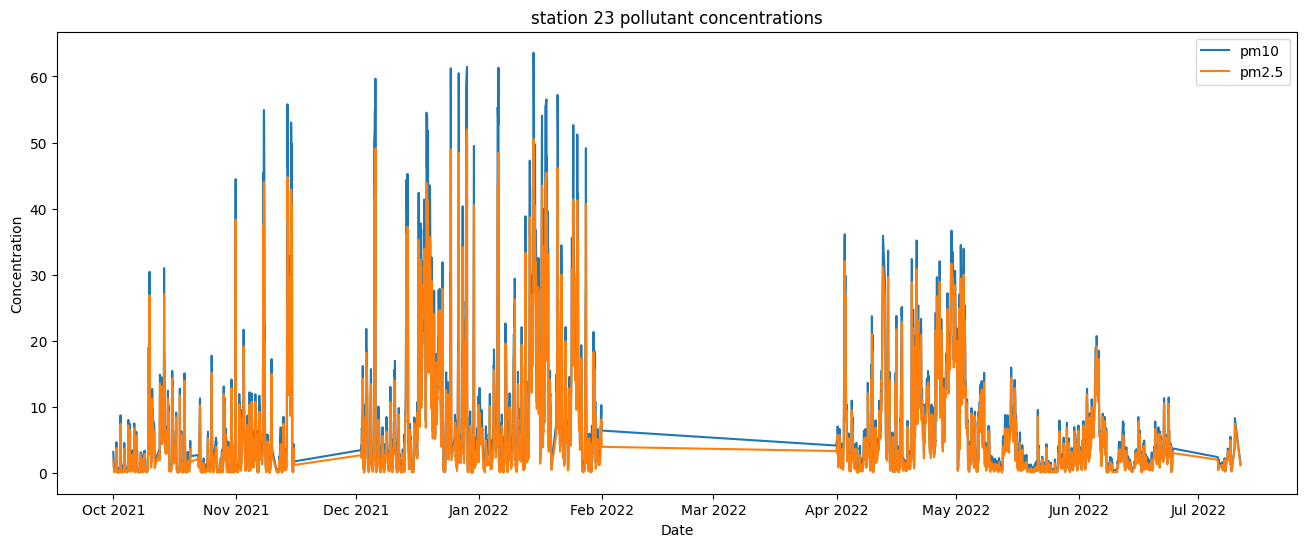

In [71]:
plt_sensor(s2, "station 23 pollutant concentrations")

In [72]:
s2[["pm2.5(ug/m3)", "pm10(ug/m3)"]].describe()

,pm2.5(ug/m3),pm10(ug/m3)
count,4312.000000,4312.000000
mean,6.020705,7.142989
std,8.235706,9.502530
min,0.020000,0.060000
25%,0.800000,1.310000
50%,2.800000,3.530000
75%,7.502500,8.722500
max,51.980000,63.590000


In [73]:
s2_with_null = (s2.set_index('datetime')
      .reindex(pd.date_range(s2['datetime'].min(), s2['datetime'].max(), freq='1h'))
      .rename_axis(['datetime'])
      .fillna(np.nan)
      .reset_index())
s2_with_null = s2_with_null.drop(["timestamp", "sensor ID", "latitude", "longitude"], axis=1)

In [74]:
s2_with_null["pm10(ug/m3)"] = s2_with_null["pm10(ug/m3)"].fillna(s2_with_null["pm10(ug/m3)"].mean())

In [75]:
s2 = (s2.set_index('datetime')
      .reindex(pd.date_range(s2['datetime'].min(), s2['datetime'].max(), freq='1h'))
      .rename_axis(['datetime'])
      .fillna(0)
      .reset_index())

s2 = s2.drop(["timestamp", "sensor ID", "latitude", "longitude"], axis=1)

In [76]:
s2

,datetime,pm2.5(ug/m3),pm10(ug/m3)
0,2021-10-01 00:00:00,1.89,3.15
1,2021-10-01 01:00:00,1.53,2.61
2,2021-10-01 02:00:00,1.15,2.10
3,2021-10-01 03:00:00,0.89,1.80
4,2021-10-01 04:00:00,0.24,0.81
...,...,...,...
6803,2022-07-11 11:00:00,0.00,0.00
6804,2022-07-11 12:00:00,0.00,0.00
6805,2022-07-11 13:00:00,0.00,0.00
6806,2022-07-11 14:00:00,0.00,0.00


In [77]:
raw_data = pd.read_csv('../data/meterology/hly175.csv')

/var/folders/6k/3vmlhmb52cx2vjf55_z_zgg00000gn/T/ipykernel_18567/1839102533.py:1: DtypeWarning: Columns (2,4,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('../data/meterology/hly175.csv')


In [78]:
df = raw_data[['date', 'temp', 'wetb', 'dewpt', 'vappr']]
df['datetime'] = pd.to_datetime(df['date'])
df['temp'] = pd.to_numeric(df['temp'], errors='coerce')
df['wetb'] = pd.to_numeric(df['wetb'], errors='coerce')
df['dewpt'] = pd.to_numeric(df['dewpt'], errors='coerce')
df['vappr'] = pd.to_numeric(df['vappr'], errors='coerce')

/var/folders/6k/3vmlhmb52cx2vjf55_z_zgg00000gn/T/ipykernel_18567/552309073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['date'])
/var/folders/6k/3vmlhmb52cx2vjf55_z_zgg00000gn/T/ipykernel_18567/552309073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp'] = pd.to_numeric(df['temp'], errors='coerce')
/var/folders/6k/3vmlhmb52cx2vjf55_z_zgg00000gn/T/ipykernel_18567/552309073.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [79]:
met_s1 = df[(df['datetime'] >= s1["datetime"].min()) & (df['datetime'] <= s1["datetime"].max())]

In [80]:
final_s1 = pd.merge(met_s1[['datetime','temp', 'wetb', 'dewpt', 'vappr']], s1, how='left')

In [81]:
final_s1

,datetime,temp,wetb,dewpt,vappr,pm2.5(ug/m3),pm10(ug/m3)
0,2021-10-01 00:00:00,2.2,1.7,0.9,6.5,1.76,2.83
1,2021-10-01 01:00:00,2.1,1.9,1.5,6.8,1.41,2.34
2,2021-10-01 02:00:00,2.3,2.1,1.8,7.0,1.14,2.00
3,2021-10-01 03:00:00,2.5,2.3,1.9,7.0,0.79,1.52
4,2021-10-01 04:00:00,2.6,2.4,2.1,7.1,0.20,0.67
...,...,...,...,...,...,...,...
7290,2022-07-12 19:00:00,1.9,1.5,1.0,6.6,1.26,1.42
7291,2022-07-12 20:00:00,1.5,1.2,0.7,6.4,0.88,1.07
7292,2022-07-12 21:00:00,1.2,1.0,0.7,6.4,1.44,1.75
7293,2022-07-12 22:00:00,1.5,1.3,1.0,6.6,2.15,2.72


In [82]:
s1_with_null = pd.merge(met_s1[['datetime','temp', 'wetb', 'dewpt', 'vappr']], s1_with_null, how='left')

In [83]:
met_s2 = df[(df['datetime'] >= s2["datetime"].min()) & (df['datetime'] <= s2["datetime"].max())]

In [84]:
final_s2 = pd.merge(met_s2[['datetime','temp', 'wetb', 'dewpt', 'vappr']], s2, how='left')

In [85]:
final_s2

,datetime,temp,wetb,dewpt,vappr,pm2.5(ug/m3),pm10(ug/m3)
0,2021-10-01 00:00:00,2.2,1.7,0.9,6.5,1.89,3.15
1,2021-10-01 01:00:00,2.1,1.9,1.5,6.8,1.53,2.61
2,2021-10-01 02:00:00,2.3,2.1,1.8,7.0,1.15,2.10
3,2021-10-01 03:00:00,2.5,2.3,1.9,7.0,0.89,1.80
4,2021-10-01 04:00:00,2.6,2.4,2.1,7.1,0.24,0.81
...,...,...,...,...,...,...,...
6803,2022-06-12 19:00:00,4.1,3.3,2.2,7.2,0.93,1.22
6804,2022-06-12 20:00:00,4.3,3.4,2.1,7.1,2.27,2.74
6805,2022-06-12 21:00:00,3.9,3.2,2.2,7.1,3.30,3.89
6806,2022-06-12 22:00:00,3.2,2.7,1.7,6.9,2.48,3.12


In [86]:
s2_with_null = pd.merge(met_s2[['datetime','temp', 'wetb', 'dewpt', 'vappr']], s2_with_null, how='left')

In [87]:
final_s1.to_csv('../data/s1.csv')

In [88]:
final_s2.to_csv('../data/s2.csv')

In [89]:
s1_with_null.to_csv('../data/s1_with_null.csv')

In [90]:
s2_with_null.to_csv('../data/s2_with_null.csv')